In [1]:
import matplotlib.pyplot as plt

from dotenv import load_dotenv 
import os 

import pandas as pd
import geopandas as gpd

from datetime import timedelta

import requests
import json

import time

https://www.ncdc.noaa.gov/cdo-web/webservices/v2

In [2]:
la_bounds_gdf = gpd.read_file("../../Data/Inputs/Boundary_Shapefile/la_mainland.geojson")

In [3]:
sensors_gdf = gpd.read_file('../../Data/Outputs/sensors.geojson')

In [5]:
load_dotenv()

api_key = os.getenv("noaa_key") 
debug = os.getenv("DEBUG", "False") 

In [6]:
headers = {
    "token": api_key
}

In [7]:
session = requests.Session()
session.headers.update({"token": api_key})

In [ ]:
def get_response(url):
    try: 
        response = requests.get(url,headers=headers)
        data = response.json()
        return data['results']
    except:
        print(response.status_code)

In [13]:
def to_gdf(results_json):
    results_df = pd.DataFrame(results_json)
    results_gdf = gpd.GeoDataFrame(
   results_df, geometry=gpd.points_from_xy(results_df['longitude'], results_df['latitude']), crs="EPSG:4326"
)
    return results_gdf

### Location Categories

In [8]:
location_categories = get_response('https://www.ncei.noaa.gov/cdo-web/api/v2/locationcategories')

503


In [9]:
location_categories

def get_response(url, headers=headers, retries=3, timeout=60):
    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=timeout)
            response.raise_for_status()
            data = response.json()
            time.sleep(3)
            return data.get('results', [])
        except requests.exceptions.HTTPError as e:
            print(f"HTTP error {e} for URL {url}")
            return None
        except requests.exceptions.RequestException as e:
            print(f"Request error {e}, attempt {attempt + 1}/{retries}")
        except ValueError as e:
            print(f"JSON decode error for URL {url}: {e}")
            return None
    print(f"Failed to get data from {url} after {retries} attempts")
    return None

In [10]:
def get_response(url, session=session, retries=3, timeout=60):
    for attempt in range(retries):
        try:
            print(f"Making request to {url}")
            response = session.get(url, timeout=timeout)
            response.raise_for_status()
            data = response.json()
            time.sleep(3)
            return data.get('results', [])
        except requests.exceptions.HTTPError as e:
            print(f"HTTP error {e} for URL {url}")
            return None
        except requests.exceptions.RequestException as e:
            print(f"Request error {e}, attempt {attempt + 1}/{retries}")
        except ValueError as e:
            print(f"JSON decode error for URL {url}: {e}")
            return None
    print(f"Failed to get data from {url} after {retries} attempts")
    return None


Finding the ID for the state of California. It's in alphabetical order so we don't need to pull in every option, only the first 10 or so.

In [11]:
state_data = get_response('https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST&limit=10')

In [12]:
state_data[4]

{'mindate': '1850-10-01',
 'maxdate': '2025-12-11',
 'name': 'California',
 'datacoverage': 1,
 'id': 'FIPS:06'}

### Finding the FIPS code for Los Angeles County

https://www.ncdc.noaa.gov/cdo-web/webservices/v2#locations

In [13]:
counties = get_response('https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=CNTY&limit=1000&sortfield=name&sortorder=asc&offset=1000')

In [14]:
counties[733]

{'mindate': '1893-01-01',
 'maxdate': '2025-12-11',
 'name': 'Los Angeles County, CA',
 'datacoverage': 1,
 'id': 'FIPS:06037'}

### Los Angeles County Stations

https://www.ncdc.noaa.gov/cdo-web/webservices/v2#stations

In [15]:
la_stations = get_response('https://www.ncei.noaa.gov/cdo-web/api/v2/stations?locationid=FIPS:06037&limit=1000')

In [16]:
la_stations[:5]

[{'elevation': 863.5,
  'mindate': '1931-01-01',
  'maxdate': '2013-12-01',
  'latitude': 34.4938,
  'name': 'ACTON ESCONDIDO CANYON, CA US',
  'datacoverage': 0.8986,
  'id': 'COOP:040014',
  'elevationUnit': 'METERS',
  'longitude': -118.2713},
 {'elevation': 721.5,
  'mindate': '1939-09-01',
  'maxdate': '1992-10-30',
  'latitude': 34.31667,
  'name': 'ALISO CANYON FC 446, CA US',
  'datacoverage': 0.9711,
  'id': 'COOP:040115',
  'elevationUnit': 'METERS',
  'longitude': -118.55},
 {'elevation': 343.5,
  'mindate': '1931-01-01',
  'maxdate': '2015-11-01',
  'latitude': 34.18211,
  'name': 'ALTADENA, CA US',
  'datacoverage': 0.9362,
  'id': 'COOP:040144',
  'elevationUnit': 'METERS',
  'longitude': -118.13827},
 {'elevation': 371.9,
  'mindate': '1931-01-01',
  'maxdate': '1974-06-01',
  'latitude': 34.21667,
  'name': 'ARROYO SECO RANGER STATION FC508, CA US',
  'datacoverage': 0.9962,
  'id': 'COOP:040327',
  'elevationUnit': 'METERS',
  'longitude': -118.16667},
 {'elevation': 2

In [17]:
len(la_stations)

384

In [18]:
la_stations_gdf = to_gdf(la_stations)

In [19]:
la_stations_gdf.head()

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,geometry
0,863.5,1931-01-01,2013-12-01,34.49380,"ACTON ESCONDIDO CANYON, CA US",0.8986,COOP:040014,METERS,-118.27130,POINT (-118.2713 34.4938)
1,721.5,1939-09-01,1992-10-30,34.31667,"ALISO CANYON FC 446, CA US",0.9711,COOP:040115,METERS,-118.55000,POINT (-118.55 34.31667)
2,343.5,1931-01-01,2015-11-01,34.18211,"ALTADENA, CA US",0.9362,COOP:040144,METERS,-118.13827,POINT (-118.13827 34.18211)
3,371.9,1931-01-01,1974-06-01,34.21667,"ARROYO SECO RANGER STATION FC508, CA US",0.9962,COOP:040327,METERS,-118.16667,POINT (-118.16667 34.21667)
4,27.4,2011-01-01,2011-12-01,33.33800,"AVALON INLAND, CA US",1.0000,COOP:040392,METERS,-118.33050,POINT (-118.3305 33.338)


I need to verify that this is the correct crs for the NOAA data, but since it's lat/long I'll assume it's ok for now

### La County Recents

I take the extent from OpenAq/01_Data_Collection

The absolute oldest data for LA County in the OpenAQ dataset is from 2016-03-06, so I use this in the NOAA url as the start date

In [20]:
sensors_gdf.sort_values(by='datetime_first.utc').head()

,sensors_id,station_id,pollutant,name,datetime_first.utc,datetime_last.utc,timezone,is_mobile,is_monitor,bounds,...,country.name,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,instrument_name,instrument_id,geometry
0,1502,847,PM2.5,South Long Beach,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,America/Los_Angeles,False,True,"[-118.175278, 33.792221, -118.175278, 33.792221]",...,United States,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,Government Monitor,2,POINT (-118.17528 33.79222)
32,8683,1575,SO₂,Los Angeles - N. Mai,2016-03-06 20:00:00+00:00,2017-06-07 21:00:00+00:00,America/Los_Angeles,False,True,"[-118.2417, 34.0669, -118.2417, 34.0669]",...,United States,4,Unknown Governmental Organization,119,AirNow,34.066900,-118.241700,Government Monitor,2,POINT (-118.2417 34.0669)
33,2794,1585,O₃,Upland,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[-117.6733, 34.0986, -117.6733, 34.0986]",...,United States,4,Unknown Governmental Organization,119,AirNow,34.098600,-117.673300,Government Monitor,2,POINT (-117.6733 34.0986)
34,2793,1585,PM10,Upland,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[-117.6733, 34.0986, -117.6733, 34.0986]",...,United States,4,Unknown Governmental Organization,119,AirNow,34.098600,-117.673300,Government Monitor,2,POINT (-117.6733 34.0986)
35,2792,1585,PM2.5,Upland,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[-117.6733, 34.0986, -117.6733, 34.0986]",...,United States,4,Unknown Governmental Organization,119,AirNow,34.098600,-117.673300,Government Monitor,2,POINT (-117.6733 34.0986)


In [21]:
recent_stations = get_response('https://www.ncei.noaa.gov/cdo-web/api/v2/stations?locationid=FIPS:06037&startdate=2016-03-06&extent=33.7046743723892,-118.944703049253,34.823304156602,-117.646385981235&limit=1000')

In [22]:
recent_stations_gdf = to_gdf(recent_stations)

In [23]:
recent_stations_gdf.head()

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,geometry
0,155.8,2008-09-23,2024-05-24,34.168900,"GLENDALE 2.4 WSW, CA US",0.9999,GHCND:US1CALA0001,METERS,-118.294700,POINT (-118.2947 34.1689)
1,88.1,2008-10-16,2019-12-04,33.937285,"WHITTIER 3.6 ESE, CA US",0.1124,GHCND:US1CALA0002,METERS,-117.984379,POINT (-117.98438 33.93728)
2,61.0,2008-10-31,2022-06-04,33.790180,"TORRANCE 2.8 SW, CA US",0.9754,GHCND:US1CALA0003,METERS,-118.336890,POINT (-118.33689 33.79018)
3,403.3,2008-11-10,2024-03-07,34.187426,"ALTADENA 0.7 ESE, CA US",0.6690,GHCND:US1CALA0005,METERS,-118.124477,POINT (-118.12448 34.18743)
4,207.9,2008-12-11,2017-03-06,34.078600,"MONTE NIDO 0.2 SSW, CA US",0.8517,GHCND:US1CALA0008,METERS,-118.687000,POINT (-118.687 34.0786)


In [24]:
recent_stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   elevation      129 non-null    float64 
 1   mindate        129 non-null    object  
 2   maxdate        129 non-null    object  
 3   latitude       129 non-null    float64 
 4   name           129 non-null    object  
 5   datacoverage   129 non-null    float64 
 6   id             129 non-null    object  
 7   elevationUnit  129 non-null    object  
 8   longitude      129 non-null    float64 
 9   geometry       129 non-null    geometry
dtypes: float64(4), geometry(1), object(5)
memory usage: 10.2+ KB


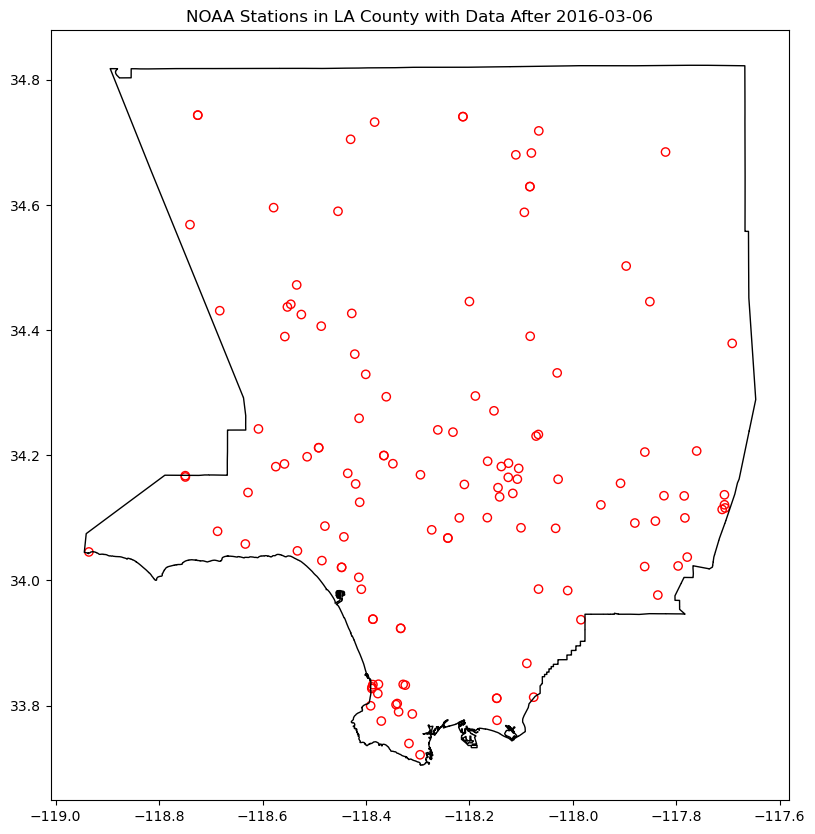

In [25]:
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');
recent_stations_gdf.plot(ax=ax, color='none', edgecolor='red');
la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');
ax.set_title('NOAA Stations in LA County with Data After 2016-03-06');

### Datasets

https://www.ncdc.noaa.gov/cdo-web/webservices/v2#datasets

In [9]:
all_datasets = get_response('https://www.ncei.noaa.gov/cdo-web/api/v2/datasets')

In [10]:
all_datasets

[{'uid': 'gov.noaa.ncdc:C00861',
  'mindate': '1763-01-01',
  'maxdate': '2025-12-10',
  'name': 'Daily Summaries',
  'datacoverage': 1,
  'id': 'GHCND'},
 {'uid': 'gov.noaa.ncdc:C00946',
  'mindate': '1763-01-01',
  'maxdate': '2025-11-01',
  'name': 'Global Summary of the Month',
  'datacoverage': 1,
  'id': 'GSOM'},
 {'uid': 'gov.noaa.ncdc:C00947',
  'mindate': '1763-01-01',
  'maxdate': '2025-01-01',
  'name': 'Global Summary of the Year',
  'datacoverage': 1,
  'id': 'GSOY'},
 {'uid': 'gov.noaa.ncdc:C00345',
  'mindate': '1991-06-05',
  'maxdate': '2025-12-11',
  'name': 'Weather Radar (Level II)',
  'datacoverage': 0.95,
  'id': 'NEXRAD2'},
 {'uid': 'gov.noaa.ncdc:C00708',
  'mindate': '1994-05-20',
  'maxdate': '2025-12-09',
  'name': 'Weather Radar (Level III)',
  'datacoverage': 0.95,
  'id': 'NEXRAD3'},
 {'uid': 'gov.noaa.ncdc:C00821',
  'mindate': '2010-01-01',
  'maxdate': '2010-01-01',
  'name': 'Normals Annual/Seasonal',
  'datacoverage': 1,
  'id': 'NORMAL_ANN'},
 {'uid'

In [28]:
len(all_datasets)

11

#### Datasets available within LA County and with most recent entries after 2016:

In [29]:
la_county_datasets = get_response('https://www.ncei.noaa.gov/cdo-web/api/v2/datasets?locationid=FIPS:06037&startdate=2016-03-06&extent=33.7046743723892,-118.944703049253,34.823304156602,-117.646385981235&limit=15')

In [30]:
la_county_datasets

[{'uid': 'gov.noaa.ncdc:C00861',
  'mindate': '1763-01-01',
  'maxdate': '2025-12-10',
  'name': 'Daily Summaries',
  'datacoverage': 1,
  'id': 'GHCND'},
 {'uid': 'gov.noaa.ncdc:C00946',
  'mindate': '1763-01-01',
  'maxdate': '2025-11-01',
  'name': 'Global Summary of the Month',
  'datacoverage': 1,
  'id': 'GSOM'},
 {'uid': 'gov.noaa.ncdc:C00947',
  'mindate': '1763-01-01',
  'maxdate': '2025-01-01',
  'name': 'Global Summary of the Year',
  'datacoverage': 1,
  'id': 'GSOY'},
 {'uid': 'gov.noaa.ncdc:C00345',
  'mindate': '1991-06-05',
  'maxdate': '2025-12-11',
  'name': 'Weather Radar (Level II)',
  'datacoverage': 0.95,
  'id': 'NEXRAD2'},
 {'uid': 'gov.noaa.ncdc:C00708',
  'mindate': '1994-05-20',
  'maxdate': '2025-12-09',
  'name': 'Weather Radar (Level III)',
  'datacoverage': 0.95,
  'id': 'NEXRAD3'}]

In [31]:
len(la_county_datasets)

5

In [32]:
la_county_datasets[0]

{'uid': 'gov.noaa.ncdc:C00861',
 'mindate': '1763-01-01',
 'maxdate': '2025-12-10',
 'name': 'Daily Summaries',
 'datacoverage': 1,
 'id': 'GHCND'}

This looks like the most promising dataset ^

### Daily Summaries

In [11]:
la_ds_stations = get_response('https://www.ncei.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&locationid=FIPS:06037&startdate=2016-03-06&extent=33.7046743723892,-118.944703049253,34.823304156602,-117.646385981235&limit=1000')

Making request to https://www.ncei.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&locationid=FIPS:06037&startdate=2016-03-06&extent=33.7046743723892,-118.944703049253,34.823304156602,-117.646385981235&limit=1000


In [14]:
la_ds_gdf = to_gdf(la_ds_stations)

In [17]:
dt_cols = la_ds_gdf.columns[1:3]
dt_cols

Index(['mindate', 'maxdate'], dtype='object')

In [18]:
for col in dt_cols:
    la_ds_gdf[col] = pd.to_datetime(la_ds_gdf[col])

In [16]:
la_ds_gdf.head()

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,geometry
0,155.8,2008-09-23,2024-05-24,34.168900,"GLENDALE 2.4 WSW, CA US",0.9829,GHCND:US1CALA0001,METERS,-118.294700,POINT (-118.2947 34.1689)
1,88.1,2008-10-16,2019-12-04,33.937285,"WHITTIER 3.6 ESE, CA US",0.1124,GHCND:US1CALA0002,METERS,-117.984379,POINT (-117.98438 33.93728)
2,61.0,2008-10-31,2022-06-04,33.790180,"TORRANCE 2.8 SW, CA US",0.9629,GHCND:US1CALA0003,METERS,-118.336890,POINT (-118.33689 33.79018)
3,403.3,2008-11-10,2024-03-07,34.187426,"ALTADENA 0.7 ESE, CA US",0.5791,GHCND:US1CALA0005,METERS,-118.124477,POINT (-118.12448 34.18743)
4,207.9,2008-12-11,2017-03-06,34.078600,"MONTE NIDO 0.2 SSW, CA US",0.8517,GHCND:US1CALA0008,METERS,-118.687000,POINT (-118.687 34.0786)


In [13]:
la_ds_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   elevation      114 non-null    float64       
 1   mindate        114 non-null    datetime64[ns]
 2   maxdate        114 non-null    datetime64[ns]
 3   latitude       114 non-null    float64       
 4   name           114 non-null    object        
 5   datacoverage   114 non-null    float64       
 6   id             114 non-null    object        
 7   elevationUnit  114 non-null    object        
 8   longitude      114 non-null    float64       
 9   geometry       114 non-null    geometry      
dtypes: datetime64[ns](2), float64(4), geometry(1), object(3)
memory usage: 9.0+ KB


In [31]:
la_ds_gdf.to_file('../../Data/Outputs/la_ds_gdf.geojson',driver='geojson')

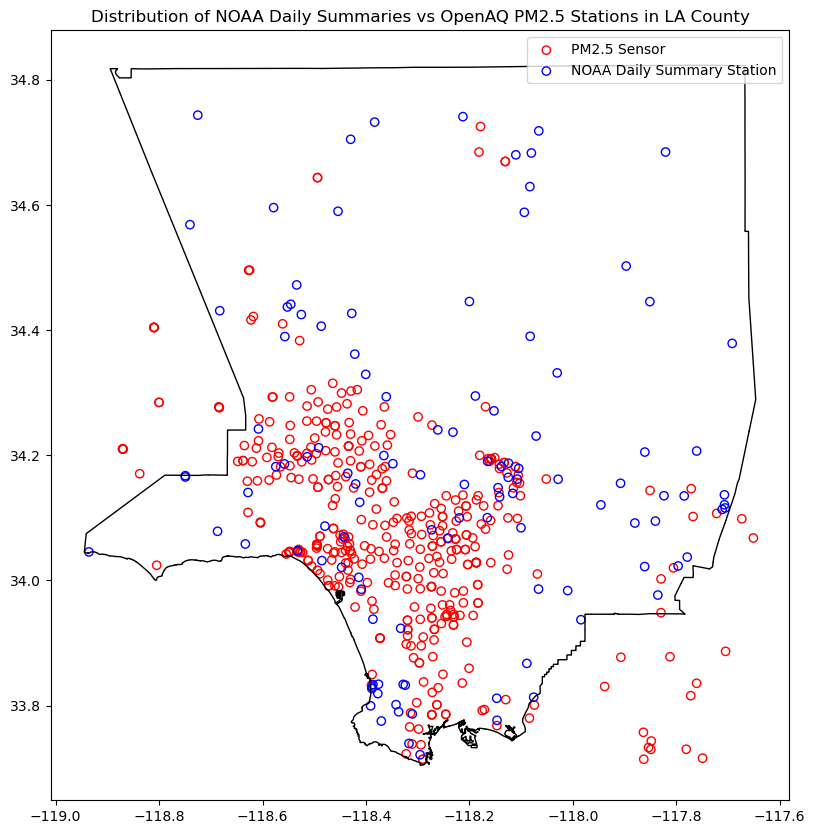

In [14]:
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');
sensors_gdf[sensors_gdf['pollutant']=='PM2.5'].plot(ax=ax, color='none', edgecolor='red', label='PM2.5 Sensor');
la_ds_gdf.plot(ax=ax, color='none', edgecolor='blue', label='NOAA Daily Summary Station');
la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');
ax.legend()
ax.set_title('Distribution of NOAA Daily Summaries vs OpenAQ PM2.5 Stations in LA County');

The Daily Summaries stations have an even spatial distribution, including in areas where the OpenAQ sensors are far more sparse. This should help with predictions in this area.

### Investigating Daily Summaries

In [15]:
la_ds_gdf.iloc[0]

elevation                            155.8
mindate                2008-09-23 00:00:00
maxdate                2024-05-24 00:00:00
latitude                           34.1689
name               GLENDALE 2.4 WSW, CA US
datacoverage                        0.9829
id                       GHCND:US1CALA0001
elevationUnit                       METERS
longitude                        -118.2947
geometry         POINT (-118.2947 34.1689)
Name: 0, dtype: object

In [16]:
la_ds_gdf.iloc[0]['id']

'GHCND:US1CALA0001'

In [17]:
US1CALA0001_ds = get_response('https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:US1CALA0001&units=standard&startdate=2022-06-02&enddate=2023-06-01')

In [18]:
US1CALA0001_ds_df = pd.DataFrame(US1CALA0001_ds)

In [19]:
US1CALA0001_ds_df.head()

,date,datatype,station,attributes,value
0,2022-06-02T00:00:00,PRCP,GHCND:US1CALA0001,",,N,0800",0.0
1,2022-06-02T00:00:00,SNOW,GHCND:US1CALA0001,",,N,0800",0.0
2,2022-06-02T00:00:00,SNWD,GHCND:US1CALA0001,",,N,0800",0.0
3,2022-06-02T00:00:00,WESD,GHCND:US1CALA0001,",,N,0800",0.0
4,2022-06-02T00:00:00,WESF,GHCND:US1CALA0001,",,N,0800",0.0


In [20]:
US1CALA0001_ds_df['datatype'].unique()

array(['PRCP', 'SNOW', 'SNWD', 'WESD', 'WESF'], dtype=object)

In [21]:
US1CALA0001_ds_df[US1CALA0001_ds_df['datatype'] == 'WESD'].head()

,date,datatype,station,attributes,value
3,2022-06-02T00:00:00,WESD,GHCND:US1CALA0001,",,N,0800",0.0
8,2022-06-03T00:00:00,WESD,GHCND:US1CALA0001,",,N,0800",0.0
13,2022-06-04T00:00:00,WESD,GHCND:US1CALA0001,",,N,0800",0.0
18,2022-06-05T00:00:00,WESD,GHCND:US1CALA0001,",,N,0800",0.0
23,2022-06-06T00:00:00,WESD,GHCND:US1CALA0001,",,N,0800",0.0


In [22]:
US1CALA0001_ds_df[US1CALA0001_ds_df['datatype'] == 'WESD']['value'].unique()

array([0.])

In [23]:
US1CALA0001_ds_df[US1CALA0001_ds_df['datatype'] == 'WESF'].head()

,date,datatype,station,attributes,value
4,2022-06-02T00:00:00,WESF,GHCND:US1CALA0001,",,N,0800",0.0
9,2022-06-03T00:00:00,WESF,GHCND:US1CALA0001,",,N,0800",0.0
14,2022-06-04T00:00:00,WESF,GHCND:US1CALA0001,",,N,0800",0.0
19,2022-06-05T00:00:00,WESF,GHCND:US1CALA0001,",,N,0800",0.0
24,2022-06-06T00:00:00,WESF,GHCND:US1CALA0001,",,N,0800",0.0


In [24]:
la_ds_gdf.iloc[0]

elevation                            155.8
mindate                2008-09-23 00:00:00
maxdate                2024-05-24 00:00:00
latitude                           34.1689
name               GLENDALE 2.4 WSW, CA US
datacoverage                        0.9829
id                       GHCND:US1CALA0001
elevationUnit                       METERS
longitude                        -118.2947
geometry         POINT (-118.2947 34.1689)
Name: 0, dtype: object

In [25]:
start_date = '2010-01-01'
end_date = '2011-01-01'

In [26]:
US1CALA0001_ds_2010 = get_response(f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:US1CALA0001&units=standard&startdate={start_date}&enddate={end_date}&limit=1000')
US1CALA0001_ds_2010_df = pd.DataFrame(US1CALA0001_ds_2010)
US1CALA0001_ds_2010_df['datatype'].unique()

array(['PRCP', 'SNOW'], dtype=object)

In [27]:
US1CALA0001_ds_2010_df.head()

,date,datatype,station,attributes,value
0,2010-01-01T00:00:00,PRCP,GHCND:US1CALA0001,",,N,0800",0.0
1,2010-01-01T00:00:00,SNOW,GHCND:US1CALA0001,",,N,0800",0.0
2,2010-01-02T00:00:00,PRCP,GHCND:US1CALA0001,",,N,0800",0.0
3,2010-01-02T00:00:00,SNOW,GHCND:US1CALA0001,",,N,0800",0.0
4,2010-01-03T00:00:00,PRCP,GHCND:US1CALA0001,",,N,0800",0.0


In [28]:
US1CALA0001_ds_2010_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        732 non-null    object 
 1   datatype    732 non-null    object 
 2   station     732 non-null    object 
 3   attributes  732 non-null    object 
 4   value       732 non-null    float64
dtypes: float64(1), object(4)
memory usage: 28.7+ KB


### Complete DS Dataset

The oldest OpenAQ reading in LA is from 2016-03-06, so I will set this as the mindate for NOAA

OpenAQ states that their dates are in `YYYY-MM-DD` format, as does NOAA:

https://docs.openaq.org/using-the-api/dates-datetimes

https://www.ncdc.noaa.gov/cdo-web/webservices/v2#data

In [17]:
len(la_ds_gdf)

114

There are 114 daily summary stations in LA county.

In [30]:
la_ds_gdf.head()

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,geometry
0,155.8,2008-09-23,2024-05-24,34.168900,"GLENDALE 2.4 WSW, CA US",0.9829,GHCND:US1CALA0001,METERS,-118.294700,POINT (-118.2947 34.1689)
1,88.1,2008-10-16,2019-12-04,33.937285,"WHITTIER 3.6 ESE, CA US",0.1124,GHCND:US1CALA0002,METERS,-117.984379,POINT (-117.98438 33.93728)
2,61.0,2008-10-31,2022-06-04,33.790180,"TORRANCE 2.8 SW, CA US",0.9629,GHCND:US1CALA0003,METERS,-118.336890,POINT (-118.33689 33.79018)
3,403.3,2008-11-10,2024-03-07,34.187426,"ALTADENA 0.7 ESE, CA US",0.5791,GHCND:US1CALA0005,METERS,-118.124477,POINT (-118.12448 34.18743)
4,207.9,2008-12-11,2017-03-06,34.078600,"MONTE NIDO 0.2 SSW, CA US",0.8517,GHCND:US1CALA0008,METERS,-118.687000,POINT (-118.687 34.0786)


In [31]:
la_ds_gdf.shape

(114, 10)

In [32]:
la_ds_gdf.columns

Index(['elevation', 'mindate', 'maxdate', 'latitude', 'name', 'datacoverage',
       'id', 'elevationUnit', 'longitude', 'geometry'],
      dtype='object')

In [33]:
la_ds_gdf['maxdate'][0].date()

datetime.date(2024, 5, 24)

In [34]:
la_ds_gdf['maxdate'][0]

Timestamp('2024-05-24 00:00:00')

all_results = []
limit = 1000
offset = 0
start_date = pd.to_datetime('2016-03-06')
station_id = la_ds_gdf['id'][0]

while True:
    url = f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid={station_id}&units=standard&startdate={start_date.date()}&enddate={end_date.date()}&limit={limit}&offset={offset}'
    results = get_response(url)

    if not results:
        break

mem = get_response(f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid={la_ds_gdf['id'][0]}&units=standard&startdate={start_date.date()}&enddate={end_date.date()}&limit={1000}&offset={100000}')

In [18]:
year_delta = timedelta(days=365)

In [27]:
1/'i'

TypeError: unsupported operand type(s) for /: 'int' and 'str'

In [30]:
for i in [1,2,4,'1',2,5]:
    try:
        mem = 1/i
        print(mem)
    except TypeError:
        print("Type error you fuqqin eejit")
    except:
        print('Unknown error')

1.0
0.5
0.25
Type error you fuqqin eejit
0.5
0.2


^ A try/except block won't break the loop

def get_response(url, headers=headers, retries=3, timeout=60):
    for attempt in range(retries):
        try:
            # I don't want to print my actual token, so I modify the session.headers response
            print(f"Making request to {url} with headers: {str(session.headers).split(':')[:-2]}")
            response = requests.get(url, headers=headers, timeout=timeout)
            response.raise_for_status()
            data = response.json()
            time.sleep(3)
            return data.get('results', [])
        except requests.exceptions.HTTPError as e:
            print(f"HTTP error {e} for URL {url}")
            return None
        except requests.exceptions.RequestException as e:
            print(f"Request error {e}, attempt {attempt + 1}/{retries}")
        except ValueError as e:
            print(f"JSON decode error for URL {url}: {e}")
            return None
    print(f"Failed to get data from {url} after {retries} attempts")
    return None

def download_station_data(staion = int, dataset = str):
    
    all_results = []
    
    year_delta = timedelta(days = 365)
    
    start_date = pd.to_datetime("2016-03-06")
    end_date = start_date + year_delta
    maxdate = la_ds_gdf['maxdate'][station]
    limit = 1000
    
    while start_date < maxdate:
    
        offset = 0
        year_has_data = False
    
        while True:
            url = f"https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid={dataset}&stationid={la_ds_gdf['id'][station]}&units=standard&startdate={start_date.date()}&enddate={end_date.date()}&limit={limit}&offset={offset}"
            results = get_response(url)
    
            if results is None:
                print(f"ERROR: request failed for URL:\n{url}")
                break
    
            if not results:
                break
    
            year_has_data = True
            all_results.extend(results)
    
            offset += limit
    
        if not year_has_data:
            break
    
        start_date += year_delta
        end_date += year_delta

    results_df = pd.DataFrame(all_results)
    results_df['longitude'] = la_ds_gdf.iloc[station]['longitude']
    results_df['latitude'] = la_ds_gdf.iloc[station]['latitude']
    results_gdf = gpd.GeoDataFrame(results_df, geometry = gpd.points_from_xy(results_df['longitude'], results_df['latitude']), crs="EPSG:4326")

    return results_gdf

la_GHCND = gpd.GeoDataFrame(columns = ['data', 'datatype', 'station', 'attributes', 'value', 'longitude', 'latitude', 'geometry'])

In [75]:
for station in range(len(la_ds_gdf)):
    results_gdf = download_station_data(station, 'GHCND')
    la_GHCND = pd.concat([la_GHCND, results_gdf], ignore_index=True)

Making request to https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:US1CALA0001&units=standard&startdate=2016-03-06&enddate=2017-03-06&limit=1000&offset=0 with headers: {'User-Agent': 'python-requests/2.32.5', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'token': 'QBzqRxBKUHUOpoLVBhEeXsYmSsRciZwk'}
Making request to https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:US1CALA0001&units=standard&startdate=2016-03-06&enddate=2017-03-06&limit=1000&offset=1000 with headers: {'User-Agent': 'python-requests/2.32.5', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'token': 'QBzqRxBKUHUOpoLVBhEeXsYmSsRciZwk'}
Making request to https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:US1CALA0001&units=standard&startdate=2016-03-06&enddate=2017-03-06&limit=1000&offset=2000 with headers: {'User-Agent': 'python-requests/2.32.5', 'Accept-

/tmp/ipykernel_34997/3492136261.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  la_GHCND = pd.concat([la_GHCND, results_gdf], ignore_index=True)


Making request to https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:US1CALA0002&units=standard&startdate=2016-03-06&enddate=2017-03-06&limit=1000&offset=0 with headers: {'User-Agent': 'python-requests/2.32.5', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'token': 'QBzqRxBKUHUOpoLVBhEeXsYmSsRciZwk'}
Making request to https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:US1CALA0002&units=standard&startdate=2016-03-06&enddate=2017-03-06&limit=1000&offset=1000 with headers: {'User-Agent': 'python-requests/2.32.5', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'token': 'QBzqRxBKUHUOpoLVBhEeXsYmSsRciZwk'}
Making request to https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:US1CALA0002&units=standard&startdate=2017-03-06&enddate=2018-03-06&limit=1000&offset=0 with headers: {'User-Agent': 'python-requests/2.32.5', 'Accept-Enc

1. Handle completely null dataframes:

   ``` Python:
   /tmp/ipykernel_34997/3492136261.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  la_GHCND = pd.concat([la_GHCND, results_gdf], ignore_index=True)
  ```

2. Revise `print(f"Making request to {url} with headers: {session.headers}")` so that we don't print our token

In [76]:
la_GHCND.head()

,data,datatype,station,attributes,value,longitude,latitude,geometry,date
0,NaN,PRCP,GHCND:US1CALA0001,",,N,0800",1.57,-118.2947,34.1689,POINT (-118.2947 34.1689),2016-03-06T00:00:00
1,NaN,SNOW,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,34.1689,POINT (-118.2947 34.1689),2016-03-06T00:00:00
2,NaN,SNWD,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,34.1689,POINT (-118.2947 34.1689),2016-03-06T00:00:00
3,NaN,PRCP,GHCND:US1CALA0001,",,N,0800",0.21,-118.2947,34.1689,POINT (-118.2947 34.1689),2016-03-07T00:00:00
4,NaN,SNOW,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,34.1689,POINT (-118.2947 34.1689),2016-03-07T00:00:00


In [80]:
la_GHCND.to_file("../../Data/Outputs/LA_GHCND.geojson", driver="GeoJSON")

la_GHCND_backup = la_GHCND

la_GHCND_backup.to_file("../../Data/Outputs/LA_GHCND_backup.geojson", driver="GeoJSON")

In [2]:
gpd.read_file("../../Data/Outputs/LA_GHCND.geojson")

NameError: name 'gpd' is not defined

In [77]:
la_GHCND.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 561855 entries, 0 to 561854
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   data        0 non-null       object  
 1   datatype    561855 non-null  object  
 2   station     561855 non-null  object  
 3   attributes  561855 non-null  object  
 4   value       561855 non-null  float64 
 5   longitude   561855 non-null  float64 
 6   latitude    561855 non-null  float64 
 7   geometry    561855 non-null  geometry
 8   date        561855 non-null  object  
dtypes: float64(3), geometry(1), object(5)
memory usage: 38.6+ MB


In [127]:
str(session.headers).split(':')[:-2]

AttributeError: 'list' object has no attribute 'reduce'

In [97]:
print(list(session.headers)[:-1])

['User-Agent', 'Accept-Encoding', 'Accept', 'Connection']


In [79]:
print(type(session.headers))

<class 'requests.structures.CaseInsensitiveDict'>


In [ ]:
1/0

In [94]:
session.headers.keys()

KeysView({'User-Agent': 'python-requests/2.32.5', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'token': 'QBzqRxBKUHUOpoLVBhEeXsYmSsRciZwk'})

In [96]:
list(session.headers)

['User-Agent', 'Accept-Encoding', 'Accept', 'Connection', 'token']

In [92]:
list(session.headers.keys())[:-1]

['User-Agent', 'Accept-Encoding', 'Accept', 'Connection']

In [88]:
print(session.headers['User-Agent'], session.headers['Accept-Encoding'])

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2034314392.py, line 1)

----

### Attempt at further refining download_station_data()

In [ ]:
def get_response(url, headers=headers, retries=3, timeout=60):
    for attempt in range(retries):
        try:
            # I don't want to print my actual token, so I modify the session.headers response
            # print(f"Making request to {url} with headers: {str(session.headers).split(':')[:-2]}")
            response = requests.get(url, headers=headers, timeout=timeout)
            response.raise_for_status()
            data = response.json()
            time.sleep(3)
            return data.get('results', [])
        except requests.exceptions.HTTPError as e:
            print(f"HTTP error {e} for URL {url}")
            return None
        except requests.exceptions.RequestException as e:
            print(f"Request error {e}, attempt {attempt + 1}/{retries}")
        except ValueError as e:
            print(f"JSON decode error for URL {url}: {e}")
            return None
    print(f"Failed to get data from {url} after {retries} attempts")
    return None

In [ ]:
def download_station_data(staion = int, dataset = str):
    
    all_results = []
    all_messages = []
    
    year_delta = timedelta(days = 365)
    
    start_date = pd.to_datetime("2016-03-06")
    end_date = start_date + year_delta
    maxdate = la_ds_gdf['maxdate'][station]
    limit = 1000
    
    while start_date < maxdate:
    
        offset = 0
        year_has_data = False
    
        # ---------- PAGING LOOP ----------
        while True:
            url = (
                f"https://www.ncei.noaa.gov/cdo-web/api/v2/data?"
                f"datasetid={dataset}&stationid={la_ds_gdf['id'][station]}"
                f"&units=standard&startdate={start_date.date()}"
                f"&enddate={end_date.date()}"
                f"&limit={limit}&offset={offset}"
            )
    
            results = get_response(url)
    
            # --- if get_response failed, STOP with proper error
            if results is None:
                all_messages.extend(f"ERROR: request failed for URL:\n{url}")
                break
    
            # --- if page is empty, stop paging for this year
            if not results:
                break
    
            # add rows
            year_has_data = True
            all_results.extend(results)
    
            # next page
            offset += limit
            time.sleep(2)
    
        # ---------- AFTER PAGING ----------
        if not year_has_data:
            # no data for this year means we are done
            break
    
        # advance to next year
        start_date += year_delta
        end_date += year_delta

    results_df = pd.DataFrame(all_results)
    results_df['longitude'] = la_ds_gdf.iloc[station]['longitude']
    results_df['latitude'] = la_ds_gdf.iloc[station]['latitude']
    results_gdf = gpd.GeoDataFrame(results_df, geometry = gpd.points_from_xy(results_df['longitude'], results_df['latitude']), crs="EPSG:4326")
    messages_df = pd.DataFrame(all_messages)
    
    return results_gdf, messages_df

In [ ]:
for station in range(len(la_ds_gdf)):
    results_gdf, messages = download_station_data(station, 'GHCND')
    la_GHCND = pd.concat([la_GHCND, results_gdf], ignore_index=True)
    all_messages.extend(messages)

This still:

1. Doesn't properly handle all nulls
2. Still will display api key

print("API key:", api_key)

In [ ]:
1/0

In [ ]:
test_gdf = gpd.GeoDataFrame(test_df, geometry = gpd.points_from_xy(test_df['longitude'], test_df['latitude']), crs="EPSG:4326")

In [49]:
test2_gdf = test_gdf

In [57]:
gdf_combined = pd.concat([test_gdf, gdf_combined], ignore_index=True)

In [58]:
gdf_combined

,date,datatype,station,attributes,value,longitude,latitude,geometry
0,2016-03-06T00:00:00,PRCP,GHCND:US1CALA0001,",,N,0800",1.57,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
1,2016-03-06T00:00:00,SNOW,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
2,2016-03-06T00:00:00,SNWD,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
3,2016-03-07T00:00:00,PRCP,GHCND:US1CALA0001,",,N,0800",0.21,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
4,2016-03-07T00:00:00,SNOW,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
...,...,...,...,...,...,...,...,...
40453,2024-05-24T00:00:00,PRCP,GHCND:US1CALA0001,"T,,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
40454,2024-05-24T00:00:00,SNOW,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
40455,2024-05-24T00:00:00,SNWD,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
40456,2024-05-24T00:00:00,WESD,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)


In [44]:
stations_results_gdf = gpd.GeoDataFrame(columns = test_df.columns)

In [45]:
stations_results_gdf

,date,datatype,station,attributes,value,longitude,latitude


In [ ]:
results_df['longitude'] = la_ds_gdf.iloc[0]['longitude']
results_df['latitude'] = la_ds_gdf.iloc[0]['latitude']

In [36]:
len(all_results)

13486

In [35]:
all_results[:10]

[{'date': '2016-03-06T00:00:00',
  'datatype': 'PRCP',
  'station': 'GHCND:US1CALA0001',
  'attributes': ',,N,0800',
  'value': 1.57},
 {'date': '2016-03-06T00:00:00',
  'datatype': 'SNOW',
  'station': 'GHCND:US1CALA0001',
  'attributes': ',,N,0800',
  'value': 0.0},
 {'date': '2016-03-06T00:00:00',
  'datatype': 'SNWD',
  'station': 'GHCND:US1CALA0001',
  'attributes': ',,N,0800',
  'value': 0.0},
 {'date': '2016-03-07T00:00:00',
  'datatype': 'PRCP',
  'station': 'GHCND:US1CALA0001',
  'attributes': ',,N,0800',
  'value': 0.21},
 {'date': '2016-03-07T00:00:00',
  'datatype': 'SNOW',
  'station': 'GHCND:US1CALA0001',
  'attributes': ',,N,0800',
  'value': 0.0},
 {'date': '2016-03-07T00:00:00',
  'datatype': 'SNWD',
  'station': 'GHCND:US1CALA0001',
  'attributes': ',,N,0800',
  'value': 0.0},
 {'date': '2016-03-08T00:00:00',
  'datatype': 'PRCP',
  'station': 'GHCND:US1CALA0001',
  'attributes': 'T,,N,0800',
  'value': 0.0},
 {'date': '2016-03-08T00:00:00',
  'datatype': 'SNOW',
  's

In [36]:
all_results = []
offset = 0
limit = 1000
start_date = pd.to_datetime('2016-03-06')
end_date = start_date + year_delta

while start_date < la_ds_gdf['maxdate'][0]:
    offset = 0
    year_has_data = False
    
    while True:
        url = f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid={la_ds_gdf['id'][0]}&units=standard&startdate={start_date.date()}&enddate={end_date.date()}&limit={limit}&offset={offset}'
        results = get_response(url)
        time.sleep(1)
    
        if not results:
            break
    
        year_has_data = True
        all_results.extend(results)
        offset += 1000

        if not year_has_data:
            break
    
        start_date += year_delta
        end_date += year_delta

200
200
200
200
503


In [37]:
len(all_results)

6894

This may or may not have worked. My error and response code handling is extremely crude because of my get_response() function. I should just re-write that function inside of my while loop with better error handling.

In [37]:
test_df = pd.DataFrame(all_results)

In [38]:
test_df['longitude'] = la_ds_gdf.iloc[0]['longitude']
test_df['latitude'] = la_ds_gdf.iloc[0]['longitude']

In [39]:
test_gdf = gpd.GeoDataFrame(test_df, geometry = gpd.points_from_xy(test_df['longitude'], test_df['latitude']), crs="EPSG:4326")

In [40]:
test_gdf.head()

,date,datatype,station,attributes,value,longitude,latitude,geometry
0,2016-03-06T00:00:00,PRCP,GHCND:US1CALA0001,",,N,0800",1.57,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
1,2016-03-06T00:00:00,SNOW,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
2,2016-03-06T00:00:00,SNWD,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
3,2016-03-07T00:00:00,PRCP,GHCND:US1CALA0001,",,N,0800",0.21,-118.2947,-118.2947,POINT (-118.2947 -118.2947)
4,2016-03-07T00:00:00,SNOW,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,-118.2947,POINT (-118.2947 -118.2947)


In [44]:
test_gdf['datatype'].unique()

array(['PRCP', 'SNOW', 'SNWD', 'WESD', 'WESF', 'DAPR', 'MDPR'],
      dtype=object)

In [45]:
test_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6894 entries, 0 to 6893
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   date        6894 non-null   object  
 1   datatype    6894 non-null   object  
 2   station     6894 non-null   object  
 3   attributes  6894 non-null   object  
 4   value       6894 non-null   float64 
 5   longitude   6894 non-null   float64 
 6   latitude    6894 non-null   float64 
 7   geometry    6894 non-null   geometry
dtypes: float64(3), geometry(1), object(4)
memory usage: 431.0+ KB


Once I improve the error and message handling (messages indicating when we're reached the end of paging for a given year, etc.) we can probably fairly easily implement looping through stations. The best option would likely be what I've done above: create a gdf for each station via the lat and long of the station: `la_ds_gdf.iloc[0]['longitude']` . . . since we will already be looping via `la_ds_gdf.iloc[i]['longitude']`

In [39]:
1/0

ZeroDivisionError: division by zero

In [ ]:
all_results = []
offset = 0
limit = 1000

while True:
    url = f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid={station_id}&units=standard&startdate={start_date.date()}&enddate={end_date.date()}&limit={limit}&offset={offset}'
    results = get_response(url)

    if not results:
        start_date += year_delta
        end_date += year_delta

    all_results.extend(results)
    offset += limit

In [ ]:
la_ds_gdf.iloc[0]['id']

In [ ]:
la_ds_gdf.iloc[0]['maxdate']

In [ ]:
station_id = la_ds_gdf.iloc[0]['id']
start_date = pd.to_datetime('2016-03-06')
end_date = start_date + year_delta

In [ ]:
print(station_id)
print(start_date.date())
print(end_date.date())

In [ ]:
print(start_date.date())

In [ ]:
mem = get_response(f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid={station_id}&units=standard&startdate={start_date.date()}&enddate={end_date.date()}&limit=1000&offset=0')

In [ ]:
mem_df = pd.DataFrame(mem)

In [ ]:
len(mem_df)

https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html

In [ ]:
mem_df.head()

In [ ]:
mem_df['longitude'] = la_ds_gdf.iloc[0]['longitude']
mem_df['latitude'] = la_ds_gdf.iloc[0]['longitude']

In [ ]:
mem_df['latitude'] = la_ds_gdf.iloc[0]['latitude']

In [ ]:
mem_gdf = gpd.GeoDataFrame(mem_df, geometry=gpd.points_from_xy(mem_df['longitude'], mem_df['latitude']), crs="EPSG:4326")

In [ ]:
mem_gdf.head()

In [ ]:
len(la_ds_gdf)

In [ ]:
for i in range(len(la_ds_gdf)):
    station_id = la_ds_gdf.iloc[i]['id']
    start_date = pd.to_datetime('2016-03-06')
    end_date = start_date + year_delta
    print(i)

In [ ]:
for i in range(3):
    station_id = la_ds_gdf.iloc[i]['id']
    start_date = pd.to_datetime('2016-03-06')
    end_date = start_date + year_delta
    print(i)

In [ ]:
mem_df['geometry'] = la_ds_gdf.iloc[1]

In [ ]:
la_ds_gdf.iloc[1]

In [ ]:
mem_gdf = gpd.GeoDataFrame(mem_df, crs="EPSG:4326")

In [ ]:
len(mem_gdf)

## Examining the data

In [11]:
la_GHCND = gpd.read_file('../../Data/Outputs/LA_GHCND.geojson')

In [12]:
la_GHCND.head()

,data,datatype,station,attributes,value,longitude,latitude,date,geometry
0,None,PRCP,GHCND:US1CALA0001,",,N,0800",1.57,-118.2947,34.1689,2016-03-06,POINT (-118.2947 34.1689)
1,None,SNOW,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,34.1689,2016-03-06,POINT (-118.2947 34.1689)
2,None,SNWD,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,34.1689,2016-03-06,POINT (-118.2947 34.1689)
3,None,PRCP,GHCND:US1CALA0001,",,N,0800",0.21,-118.2947,34.1689,2016-03-07,POINT (-118.2947 34.1689)
4,None,SNOW,GHCND:US1CALA0001,",,N,0800",0.00,-118.2947,34.1689,2016-03-07,POINT (-118.2947 34.1689)


In [13]:
la_GHCND.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 561855 entries, 0 to 561854
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   data        0 non-null       object        
 1   datatype    561855 non-null  object        
 2   station     561855 non-null  object        
 3   attributes  561855 non-null  object        
 4   value       561855 non-null  float64       
 5   longitude   561855 non-null  float64       
 6   latitude    561855 non-null  float64       
 7   date        561855 non-null  datetime64[ms]
 8   geometry    561855 non-null  geometry      
dtypes: datetime64[ms](1), float64(3), geometry(1), object(4)
memory usage: 38.6+ MB


In [15]:
la_GHCND['datatype'].unique()

array(['PRCP', 'SNOW', 'SNWD', 'WESD', 'WESF', 'DAPR', 'MDPR', 'TMAX',
       'TMIN', 'TOBS', 'WT03', 'WT06', 'WT01', 'WT11', 'WT05', 'TAVG',
       'ADPT', 'ASLP', 'ASTP', 'AWBT', 'AWND', 'RHAV', 'RHMN', 'RHMX',
       'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT08', 'WT02', 'PGTM', 'WT07'],
      dtype=object)

# End of the line

This marks the end of my current working area. Everything below this is not currently active

In [ ]:
1/0

### Making a complete dataset method

I probably need to implement postGIS. I should also make sure to respect the NOAA servers by 

1. Pagenating API calls (the limit is 1000 responses per call
2. Rate limiting myself to 1-5 calls per second

In general, I estimate that I'll be getting back around a million rows, hence postgis

### Radar II 

In [ ]:
radar_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=NEXRAD3&units=standard&startdate=2010-05-01&enddate=2010-05-31'

In [ ]:
# radar_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/stations?datasetid=NEXRAD3&locationid=FIPS:06037&startdate=2016-03-06&extent=33.7046743723892,-118.944703049253,34.823304156602,-117.646385981235&limit=1000'

response = requests.get(radar_url,headers=headers)
radar_response = response.json()

In [ ]:
radar_response

In [ ]:
radar_df = pd.DataFrame(radar_res)
radar_gdf = gpd.GeoDataFrame(
   radar_df, geometry=gpd.points_from_xy(radar_df['longitude'], radar_df['latitude']), crs="EPSG:4326"
)

In [ ]:
radar_gdf

In [ ]:
'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:28801&startdate=2010-05-01&enddate=2010-05-01'

In [ ]:
test = 'https://www.ncei.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&'

At some point I should try to optimize the query using the state location code, but it doesn't seem to take:

In [ ]:
test = 'https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=FIPS:06&locationcategoryid=CNTY'

In [ ]:
response = requests.get(test,headers=headers)
print(response)
data = response.json()
data

In [ ]:
'https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=CNTY&limit=1000&sortfield=name&sortorder=asc&offset=1000'

In [ ]:
'https://www.ncei.noaa.gov/cdo-web/api/v2/locations?datasetid=GHCND&locationid=ZIP:28801&startdate=2010-05-01&enddate=2010-05-01'

In [ ]:
loc_cnty_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/locationcategories/CNTY'

In [ ]:
response = requests.get(loc_cnty_url,headers=headers)
print(response)
data = response.json()
data

### Looking for temp:

For now I will negate this section. Suffice it to say, temperature is present in some but not all stations

la_ds_gdf.iloc[5]['id']

la_ds_gdf.iloc[5]

def station_search(station_id, start_date, end_date):
    temp = get_response(f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid={station_id['id']}&units=standard&startdate={start_date}&enddate={end_date}')
    df = pd.DataFrame(temp)    
    return df

df = station_search(la_ds_gdf.iloc[100], '2019-01-01', '2020-01-01')
df['datatype'].unique()

### Stations

### Daily Summaries

https://www.ncdc.noaa.gov/cdo-web/webservices/v2#data

Example URL:

`https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=YOUR_DATASETID`

In [ ]:
url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND'

In [ ]:
1/0

In [ ]:
# Trying one of the default URLs:
url1 = ' https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:28801&startdate=2010-05-01&enddate=2010-05-01'

In [ ]:
response = requests.get(url1,headers=headers)
print(response)
data = response.json()
data

In [ ]:
counties=data['results']

In [ ]:
len(counties)